In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from imageai.Detection import ObjectDetection
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from collections import Counter
from utils import detect_color, most_frequent, most_frequent_color, get_features, get_valfeatures, get_concat_features

# for garbage collection
import gc

# for warnings
import warnings
warnings.filterwarnings("ignore")

# utility libraries
import os
import copy
import tqdm
import numpy as np 
import pandas as pd 
import cv2, random, time, shutil, csv
import tensorflow as tf
import math

# keras libraries
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
#from keras.utils import to_categorical
from keras import backend as K

In [2]:
# DEFINING models and preprocessors imports 

from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input

from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input

from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input

models = [InceptionV3,  InceptionResNetV2, Xception, ]
preprocs = [inception_preprocessor,  inc_resnet_preprocessor, 
            xception_preprocessor, ]

#load trained models for breeds
trained_models_ = []
for i in range(0, 2, 1):
    model_file_name = 'models/breed/trained_model_' + str(i)
    trained_models_.append(keras.models.load_model(model_file_name)) 

img_size = 331
data_df = pd.read_csv('models/breed/breeds_labels.csv')
class_names = sorted(data_df['breed'].unique())

In [3]:
def predict_breed(objects):
    X = []
    i = 0
    for image in objects:
        orig_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res_image = cv2.resize(orig_image,(img_size, img_size))
        X.append(res_image)
        i+=1

    Xtesarr = np.array(X)

    del(X)
    gc.collect()

    # FEATURE EXTRACTION OF TEST IMAGES
    test_features = get_concat_features(get_valfeatures, models, preprocs, Xtesarr)

    del(Xtesarr)
    gc.collect()
    #print('Final feature maps shape', test_features.shape)

    y_pred_norm_ = trained_models_[0].predict(test_features, batch_size=128)/3
    for dnn in trained_models_[1:]:
        y_pred_norm_ += dnn.predict(test_features, batch_size=128)/3

    tmp = np.argmax(y_pred_norm_, axis=1)
    tmp = pd.DataFrame(tmp, columns=['Predicted class'])
    tmp['Predicted class name'] = tmp['Predicted class'].apply(lambda x: class_names[x])
    breed = most_frequent(tmp['Predicted class name'])
    return breed

In [4]:
#load models for object detection
BASE_DIR = Path().resolve()

#Breeds-tails dictionary
tails_dict = pd.read_csv('models/breed/tails.csv')
tails_dict = tails_dict.set_index('breed')

# RetinaNet
detector_retina = ObjectDetection()
detector_retina.setModelTypeAsRetinaNet()
detector_retina.setModelPath(BASE_DIR / "models/resnet50_coco_best_v2.1.0.h5")
custom = detector_retina.CustomObjects(person=True, dog=True)
detector_retina.loadModel()

# YOLO
detector_yolo = ObjectDetection()
detector_yolo.setModelTypeAsYOLOv3()
detector_yolo.setModelPath(BASE_DIR / "models/yolo.h5")
custom = detector_yolo.CustomObjects(person=True, dog=True, bird=True)
detector_yolo.loadModel()


def run_all_predict(image):
    filename = ''
    is_animal_there = 0
    is_it_a_dog = 0
    is_the_owner_there = 0
    is_animal_there_retina = 0
    is_it_a_dog_retina = 0
    is_the_owner_there_retina = 0
    is_animal_there_yolo = 0
    is_it_a_dog_yolo = 0
    is_the_owner_there_yolo = 0
    color = 0
    tail = 0
    address = ''
    cam_id = ''
    
    # detect objects
    # RetinaNet
    _, objects_retina = detector_retina.detectObjectsFromImage(custom_objects=custom
                                          , input_image=image
                                          , input_type='array'
                                          , minimum_percentage_probability=5
                                          , output_type='array') 
    if len(objects_retina) > 0:
        objects_retina = pd.DataFrame(objects_retina)
        objects_retina.columns = ['name','percentage_probability','box_points']
        mask_animal = (objects_retina['name'] == 'dog')&(objects_retina['percentage_probability'] >= 7)
        is_animal_there_retina = 1 if objects_retina[mask_animal].shape[0] > 0 else 0
        mask_dog = (objects_retina['name'] == 'dog')&(objects_retina['percentage_probability'] >= 9)
        is_it_a_dog_retina = 1 if objects_retina[mask_dog].shape[0] > 0 else 0
        mask_person = (objects_retina['name'] == 'person')&(objects_retina['percentage_probability'] >= 52)
        is_the_owner_there_retina = 1 if objects_retina[mask_person].shape[0] > 0 else 0
        objects_retina = objects_retina[mask_dog]
        objects_retina['source'] = 'retina'

    # detect objects

    # YOLO
    _, objects_yolo = detector_yolo.detectObjectsFromImage(custom_objects=custom
                                          , input_image=image
                                          , input_type='array'
                                          , minimum_percentage_probability=5
                                          , output_type='array') 
    if len(objects_yolo) > 0:
        objects_yolo = pd.DataFrame(objects_yolo)
        objects_yolo.columns = ['name','percentage_probability','box_points']
        mask_animal = ((objects_yolo['name'] == 'dog')&(objects_yolo['percentage_probability'] >= 5))| \
                    ((objects_yolo['name'] == 'bird')&(objects_yolo['percentage_probability'] >= 5))
        is_animal_there_yolo = 1 if objects_yolo[mask_animal].shape[0] > 0 else 0
        mask_dog = (objects_yolo['name'] == 'dog')&(objects_yolo['percentage_probability'] >= 5)
        is_it_a_dog_yolo = 1 if objects_yolo[mask_dog].shape[0] > 0 else 0
        mask_person = (objects_yolo['name'] == 'person')&(objects_yolo['percentage_probability'] >= 60)
        is_the_owner_there_yolo = 1 if objects_yolo[mask_person].shape[0] > 0 else 0
        objects_yolo = objects_yolo[mask_dog]
        objects_yolo['source'] = 'yolo'
    
    objects_data = pd.DataFrame()
    # concatenate objects
    if len(objects_retina) > 0 and len(objects_yolo) > 0:
        objects_data = pd.concat([objects_retina, objects_yolo])
    else:
        if len(objects_retina) > 0:
            objects_data = objects_retina
        if len(objects_yolo) > 0:
            objects_data = objects_yolo
    

    # is_animal_there, is_it_a_dog, is_the_owner_there aggregate
    is_animal_there = np.max([is_animal_there_retina, is_animal_there_yolo])
    is_it_a_dog = np.max([is_it_a_dog_retina, is_it_a_dog_yolo])
    is_the_owner_there = np.max([is_the_owner_there_retina, is_the_owner_there_yolo])

    
    if len(objects_data) > 0:
        # crop images
        objects = []
        for box in objects_data['box_points']:
            cropped_image = image[box[1]:box[1]+box[3], box[0]:box[0]+box[2]] 
            objects.append(cropped_image)
            #plt.imshow(cropped_image)
            #plt.show()

        # predict color
        colors = []
        for im in objects:
            colors.append(detect_color(image))
        color = most_frequent_color(colors)

        # predict breed + tail (1 (короткий/нет хвоста), 2 (длинный))
        breed = predict_breed(objects)
        tail = tails_dict.loc[breed, 'tail']

    return [filename, is_animal_there, is_it_a_dog, is_the_owner_there, color, tail, address, cam_id]

In [5]:
## Dataset descriptive

#parse files in dataset folder

columns = ['path','file_id', 'dog', 'human', 'animal_not_dog', 'dog_color', 'dog_tail']

def add_files(dataset_folder_path, dog, human, animal_not_dog, dog_color, dog_tail):
    dataset_files = []
    for path, subdirs, files in os.walk(dataset_folder_path):
        for name in files:
            if '_' not in name:
                dataset_files.append([os.path.join(path, name), name, dog, human, animal_not_dog, dog_color, dog_tail])
    return pd.DataFrame(dataset_files)


data = pd.concat([add_files("dataset_test\other_animals", 0, 0, 1, None, None)
                 ,add_files("dataset_test\empty", 0, 0, 0, None, None)
                 ,add_files("dataset_test\only_dog\mixed_long", 1, 0, 0, "mixed", "long")
                 ,add_files("dataset_test\only_dog\mixed_short", 1, 0, 0, "mixed", "short")
                 ,add_files("dataset_test\only_dog\light_long", 1, 0, 0, "light", "long")
                 ,add_files("dataset_test\only_dog\dark_long", 1, 0, 0, "dark", "long")
                 ,add_files("dataset_test\only_dog\dark_short", 1, 0, 0, "dark", "short")
                 ,add_files("dataset_test\only_dog\light_short", 1, 0, 0, "light", "short")
                 ,add_files("dataset_test\human_and_dog", 1, 1, 0, None, None)])

data.columns = columns

data['any_animal'] = data[['dog', 'animal_not_dog']].max(axis=1)

display(data.groupby(['dog', 'human', 'animal_not_dog', 'any_animal'])['path'].count().reset_index())
display(data.groupby(['dog', 'human', 'animal_not_dog', 'dog_color', 'dog_tail'])['path'].count().reset_index())

all_predict = []

#data_ = data.sample(frac=1)
#data_ = pd.concat([data_[data_['dog_color'] == 'light'].head(20),
#                 data_[data_['dog_color'] == 'dark'].head(20)])

for i in data['path']:
    print(i)
    BASE_DIR = Path().resolve()
    image_path = BASE_DIR / i
    try:
        image = mpimg.imread(image_path)
        #plt.imshow(image)
        all_predict.append([i] + run_all_predict(image))
    except:
        all_predict.append([i] + ['', 0, 0, 0, 0, 0, '', ''])
all_predict = pd.DataFrame(all_predict) 
all_predict.columns = ['id', 'filename', 'is_animal_there', 'is_it_a_dog', 'is_the_owner_there', 'color', 'tail', 'address', 'cam_id']
all_predict.to_csv('predict_all.csv')

pd.concat([data, all_predict.reindex(data.index)], axis=1).to_csv('predict_all_.csv')

,dog,human,animal_not_dog,any_animal,path
0,0,0,0,0,48
1,0,0,1,1,33
2,1,0,0,1,171
3,1,1,0,1,62


,dog,human,animal_not_dog,dog_color,dog_tail,path
0,1,0,0,dark,long,24
1,1,0,0,dark,short,28
2,1,0,0,light,long,31
3,1,0,0,light,short,32
4,1,0,0,mixed,long,29
5,1,0,0,mixed,short,27


dataset_test\other_animals\B105.jpg
1/1 [==============================] - 1s 975ms/step
dataset_test\other_animals\B106.jpg
dataset_test\other_animals\B108.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\other_animals\B109.jpg
1/1 [==============================] - 1s 934ms/step
dataset_test\other_animals\B113.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\other_animals\B114.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\other_animals\B13.jpg
1/1 [==============================] - 1s 796ms/step
dataset_test\other_animals\B15.jpg
dataset_test\other_animals\B3.jpg
dataset_test\other_animals\B42.jpg
dataset_test\other_animals\B61.jpg
1/1 [==============================] - 1s 949ms/step
dataset_test\other_animals\B62.jpg
dataset_test\other_animals\B63.jpg
dataset_test\other_animals\B67.jpg
1/1 [==============================] - 1s 927ms/step
dataset_test\other_animals\B7.jpg
1/1 [==============================] - 1s 996ms/step
dat

1/1 [==============================] - 3s 3s/step
dataset_test\only_dog\mixed_long\B60.jpg
dataset_test\only_dog\mixed_long\B69.jpg
1/1 [==============================] - 3s 3s/step
dataset_test\only_dog\mixed_long\B70.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\mixed_long\B82.jpg
dataset_test\only_dog\mixed_long\А102.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\mixed_long\А11.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\mixed_long\А21.jpg
dataset_test\only_dog\mixed_long\А26.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\mixed_long\А34.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\mixed_long\А53.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\mixed_long\А59.jpg
1/1 [==============================] - 1s 908ms/step
dataset_test\only_dog\mixed_long\А67.jpg
1/1 [==============================] - 1s 1s/step
data

1/1 [==============================] - 1s 943ms/step
dataset_test\only_dog\light_long\B56.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\light_long\B6.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\light_long\B65.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\light_long\B83.jpg
dataset_test\only_dog\light_long\B84.jpg
dataset_test\only_dog\light_long\B94.jpg
dataset_test\only_dog\light_long\А13.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\light_long\А27.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\light_long\А28.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\light_long\А41.jpg
1/1 [==============================] - 1s 954ms/step
dataset_test\only_dog\light_long\А43.jpg
dataset_test\only_dog\light_long\А44.jpg
dataset_test\only_dog\light_long\А51.jpg
1/1 [==============================] - 2s 2s/step
dataset_test

1/1 [==============================] - 5s 5s/step
dataset_test\only_dog\dark_short\B25.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\dark_short\B32.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\dark_short\B37.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\dark_short\B39.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\dark_short\B41.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\dark_short\B52.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\dark_short\B59.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\only_dog\dark_short\B66.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\dark_short\B78.jpg
dataset_test\only_dog\dark_short\B90.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\only_dog\dark_short\А10.jpg
dataset_test\only_dog\dark_short\А16.jpg
dataset_

1/1 [==============================] - 2s 2s/step
dataset_test\human_and_dog\B38.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\human_and_dog\B58.jpg
1/1 [==============================] - 4s 4s/step
dataset_test\human_and_dog\B68.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\human_and_dog\B72.jpg
1/1 [==============================] - 2s 2s/step
dataset_test\human_and_dog\B8.jpg
dataset_test\human_and_dog\B81.jpg
dataset_test\human_and_dog\А14.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\human_and_dog\А15.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\human_and_dog\А18.jpg
1/1 [==============================] - 1s 975ms/step
dataset_test\human_and_dog\А2.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\human_and_dog\А22.jpg
1/1 [==============================] - 1s 1s/step
dataset_test\human_and_dog\А24.jpg
dataset_test\human_and_dog\А29.jpg
1/1 [==============================] - 2s 2s

1/1 [==============================] - 2s 2s/step


['', 1, 1, 0, 2, 'long', '', '']

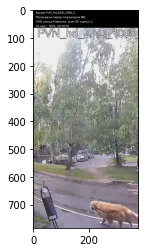

In [6]:
#
#image_path = BASE_DIR / 'data/6127.jpg'
image = mpimg.imread('data/6127.jpg')
plt.imshow(image)
run_all_predict(image)

In [6]:
## Dataset descriptive

#parse files in dataset folder

columns = ['path','file_id', 'dog', 'human', 'animal_not_dog', 'dog_color', 'dog_tail']

def add_files(dataset_folder_path, dog, human, animal_not_dog, dog_color, dog_tail):
    dataset_files = []
    for path, subdirs, files in os.walk(dataset_folder_path):
        for name in files:
            if '_' not in name:
                dataset_files.append([os.path.join(path, name), name, dog, human, animal_not_dog, dog_color, dog_tail])
    return pd.DataFrame(dataset_files)


data = pd.concat([add_files("dataset\other_animals", 0, 0, 1, None, None)
                 ,add_files("dataset\empty", 0, 0, 0, None, None)
                 ,add_files("dataset\only_dog\mixed_long", 1, 0, 0, "mixed", "long")
                 ,add_files("dataset\only_dog\mixed_short", 1, 0, 0, "mixed", "short")
                 ,add_files("dataset\only_dog\light_long", 1, 0, 0, "light", "long")
                 ,add_files("dataset\only_dog\dark_long", 1, 0, 0, "dark", "long")
                 ,add_files("dataset\only_dog\dark_short", 1, 0, 0, "dark", "short")
                 ,add_files("dataset\only_dog\light_short", 1, 0, 0, "light", "short")
                 ,add_files("dataset\human_and_dog", 1, 1, 0, None, None)])

data.columns = columns

data['any_animal'] = data[['dog', 'animal_not_dog']].max(axis=1)

display(data.groupby(['dog', 'human', 'animal_not_dog', 'any_animal'])['path'].count().reset_index())
display(data.groupby(['dog', 'human', 'animal_not_dog', 'dog_color', 'dog_tail'])['path'].count().reset_index())

all_predict = []

data_ = data.sample(frac=1)
data_ = pd.concat([data_[data_['dog_color'] == 'light'].head(20),
                 data_[data_['dog_color'] == 'dark'].head(20)])

for i in data_['path']:
    print(i)
    BASE_DIR = Path().resolve()
    image_path = BASE_DIR / i
    try:
        image = mpimg.imread(image_path)
        #plt.imshow(image)
        all_predict.append([i] + run_all_predict(image))
    except:
        all_predict.append([i] + ['', 0, 0, 0, 0, 0, '', ''])
all_predict = pd.DataFrame(all_predict) 
all_predict.to_csv('predict_all.csv')

,dog,human,animal_not_dog,any_animal,path
0,0,0,0,0,324
1,0,0,1,1,294
2,1,0,0,1,1055
3,1,1,0,1,513


,dog,human,animal_not_dog,dog_color,dog_tail,path
0,1,0,0,dark,long,143
1,1,0,0,dark,short,211
2,1,0,0,light,long,175
3,1,0,0,light,short,243
4,1,0,0,mixed,long,123
5,1,0,0,mixed,short,160


In [9]:
## Predict text

import os
import argparse
import pytesseract
import cv2
import numpy as np

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

def filter(image):
    # grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # inverse b/w
    invert = cv2.bitwise_not(gray)
    # apply Otsu threshold
    thresh = cv2.threshold(invert, 0, 255, cv2.THRESH_OTSU)[1]
    return thresh

def get_contours(img):
    contours, _ = cv2.findContours(filter(img), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    r1, r2 = sorted(contours, key=cv2.contourArea)[-3:-1]
    x, y, w, h = cv2.boundingRect(np.r_[r1, r2])
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

def tesseract(image):
    thr = filter(image)
    ocr = pytesseract.image_to_string(thr, lang = "eng+rus", config = "--psm 1")
    print(ocr)
    if len(ocr.splitlines()) > 2:
        ocr_lines = ocr.splitlines()
        cam_id = ocr_lines[0].split(' ', 1)[1]
        addr = ocr_lines[2]
        addr = addr.lower()        
        return [cam_id, addr]
    
    else:
        return ["", ""]

#image = cv2.imread('data/137.jpg')
#plt.imshow(image)
#tesseract(image)

In [51]:
answers = pd.read_csv('mo_united_answers.csv')
t = pd.read_excel('text predict.xlsx',encoding='cp1251', sheet_name=1)

In [52]:
tt = pd.merge(answers, t, on='file_id_correct', how='left')
tt

,path,file_id_correct,filename,true_dog,true_human,true_animal_not_dog,true_dog_color,true_dog_tail,true_any_animal,is_animal_there,is_it_a_dog,is_the_owner_there,color,tail,cam_id__,adress_id__
0,dataset_test\empty\B1.jpg,B1.jpg,B1.jpg,0,0,0,NaN,NaN,0,1,1,0,1,2,PVN hd SVAO_1652.1,площадка перед подъездом №1
1,dataset_test\only_dog\dark_long\B10.jpg,B10.jpg,B10.jpg,1,0,0,dark,long,1,1,1,0,1,2,NaN,NaN
2,dataset_test\empty\B100.jpg,B100.jpg,B100.jpg,0,0,0,NaN,NaN,0,0,0,0,0,0,PVN hd UZAO_8772_3,NaN
3,dataset_test\only_dog\dark_short\B101.jpg,B101.jpg,B101.jpg,1,0,0,dark,short,1,0,0,0,0,0,,NaN
4,dataset_test\only_dog\dark_short\B102.jpg,B102.jpg,B102.jpg,1,0,0,dark,short,1,1,1,1,2,2,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,dataset_test\only_dog\mixed_long\А95.jpg,?95.jpg,?95.jpg,1,0,0,mixed,long,1,1,1,1,2,2,NaN,NaN
310,dataset_test\only_dog\mixed_long\А96.jpg,?96.jpg,?96.jpg,1,0,0,mixed,long,1,0,0,0,0,0,NaN,NaN
311,dataset_test\only_dog\light_short\А97.jpg,?97.jpg,?97.jpg,1,0,0,light,short,1,1,1,0,1,2,NaN,NaN
312,dataset_test\only_dog\dark_long\А98.jpg,?98.jpg,?98.jpg,1,0,0,dark,long,1,1,1,0,2,2,NaN,NaN


In [54]:
tt.to_excel('mo_united_answers_full.xlsx')